# Download The Library

In [2]:
!gdown 1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g -O CIFAR10.tar.gz
!tar xzf CIFAR10.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g
To: /content/CIFAR10.tar.gz
100% 19.8M/19.8M [00:00<00:00, 238MB/s]


# Inspecting The Images Using Matplotlib

At first, we get the list of directories in train folder.

In [3]:
import os

TRAIN_SET_ROOT_FOLDER = "./CIFAR10/train"
TEST_SET_ROOT_FOLDER = "./CIFAR10/test"

labels = os.listdir(TRAIN_SET_ROOT_FOLDER)
labels.sort()
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Then we show the images with their corresponding labels.

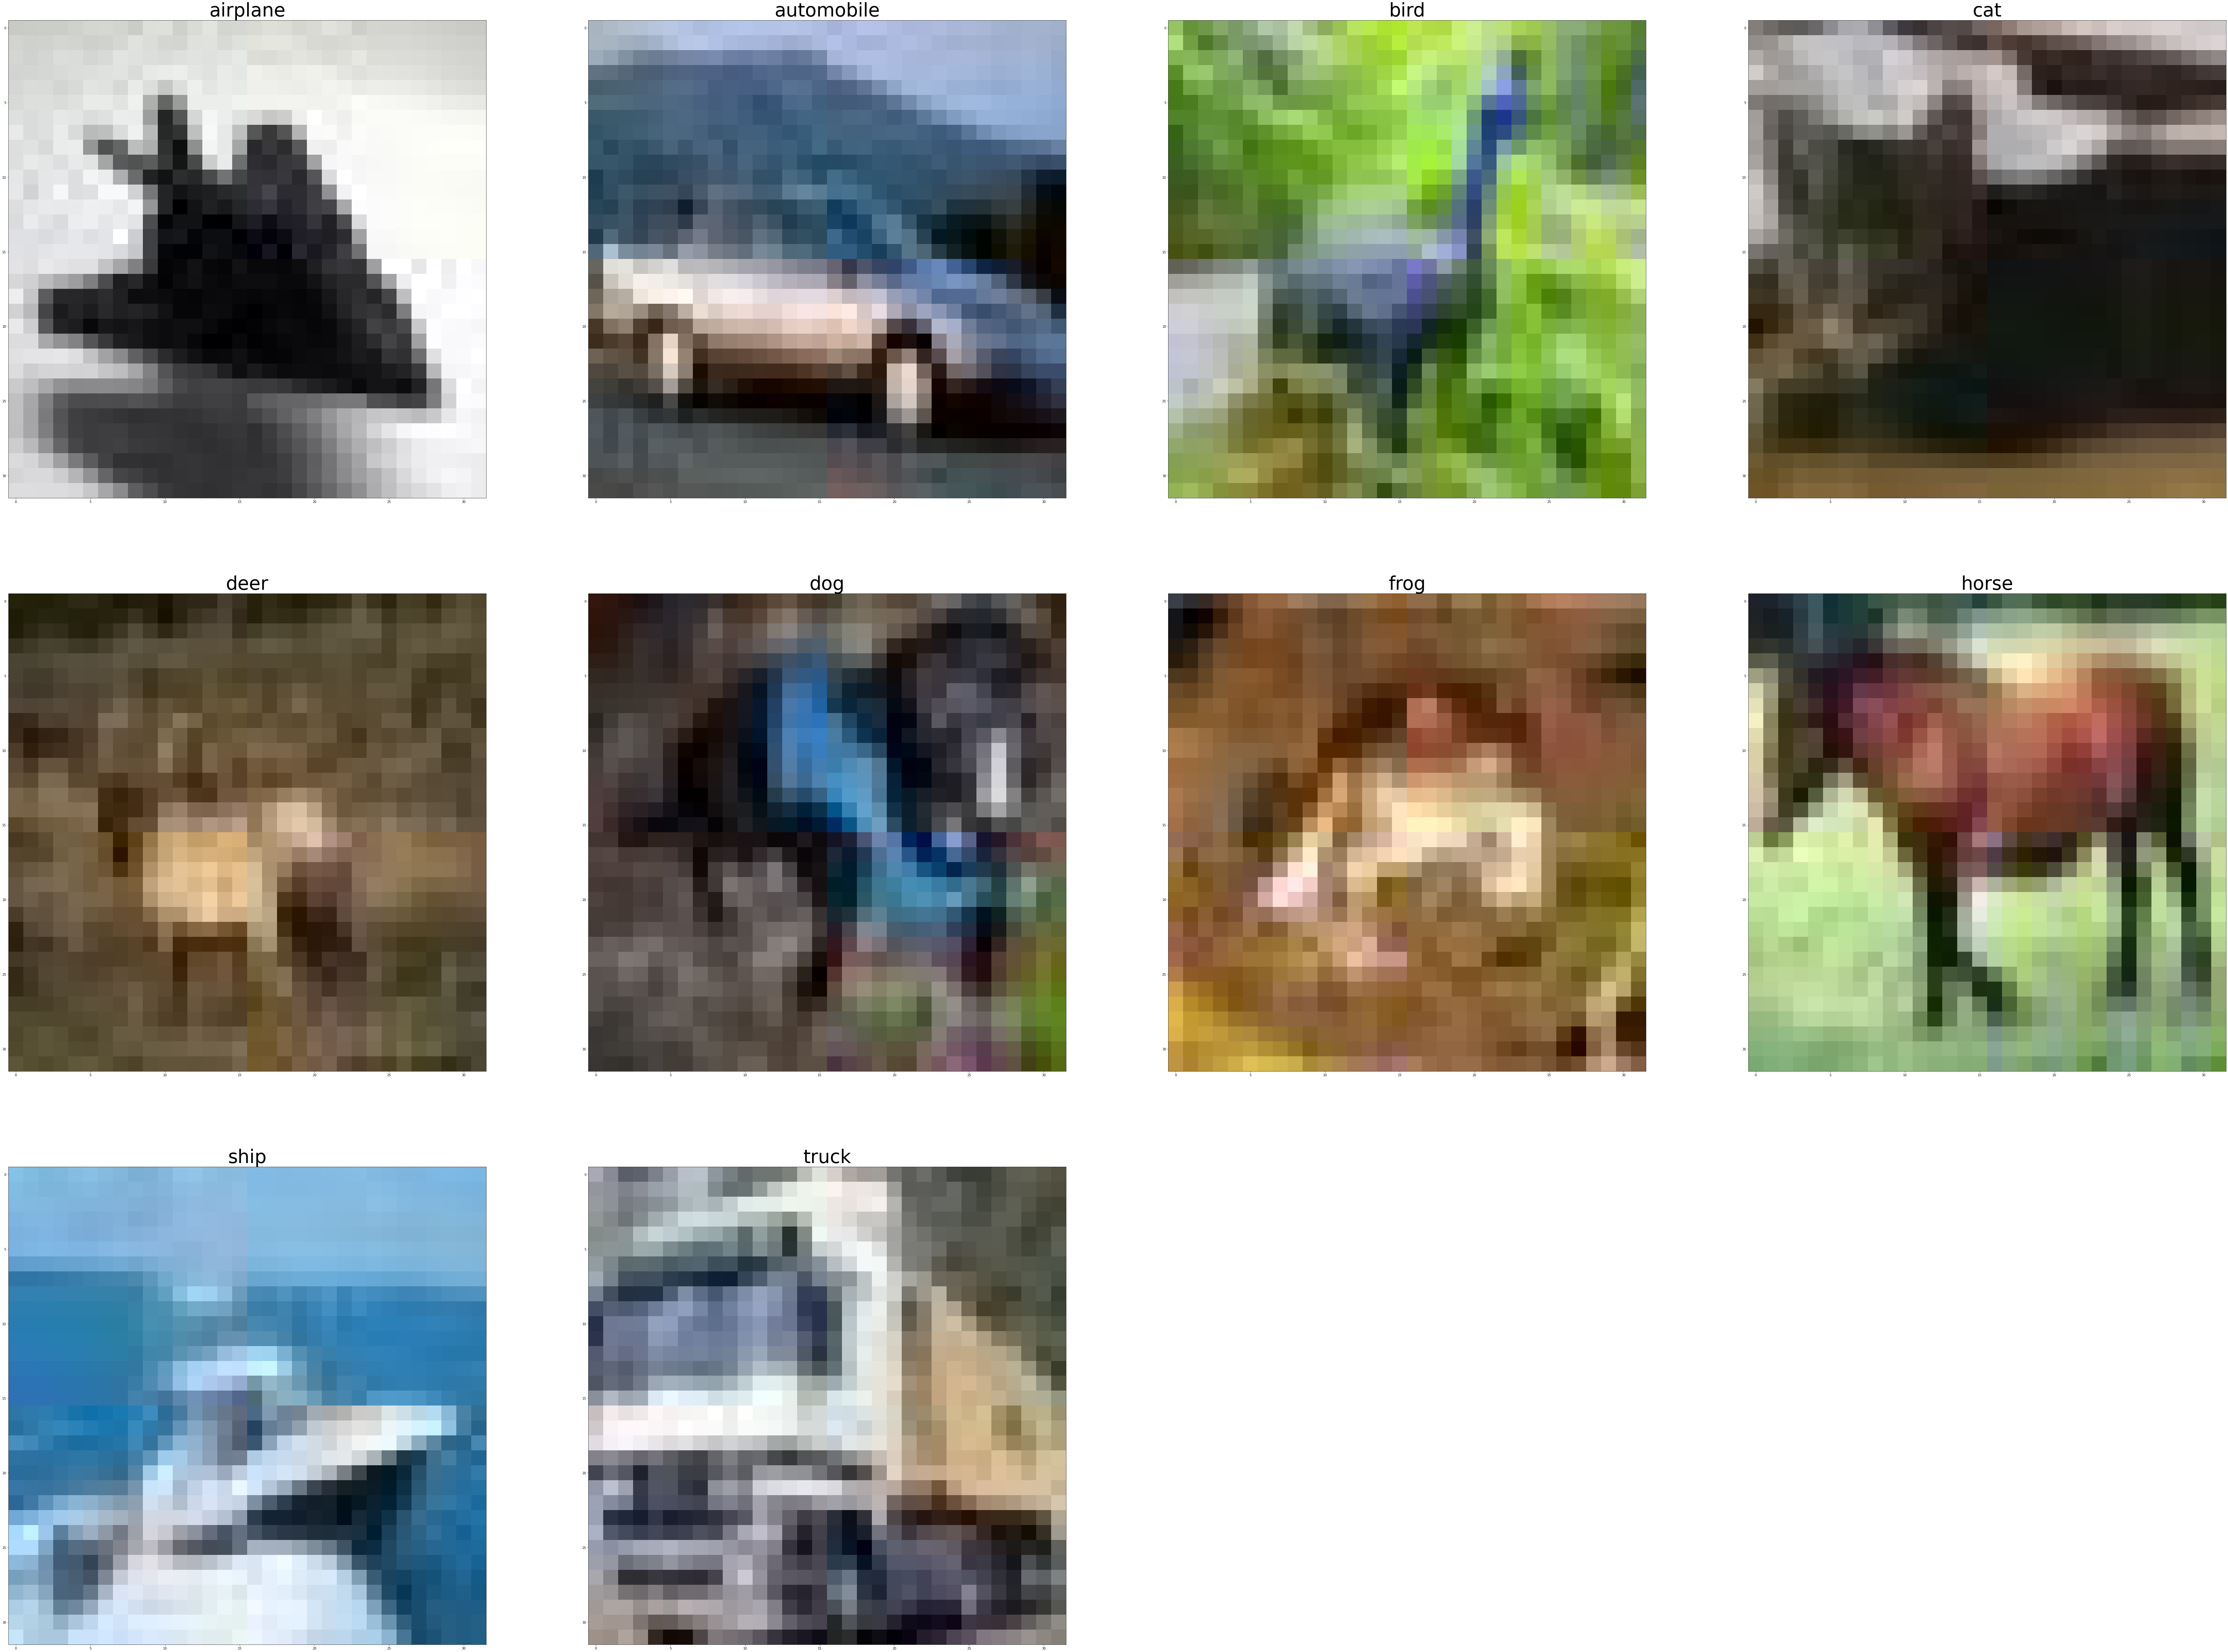

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

NEEDED_CLASSES = 4

plt.figure(figsize=(32 * NEEDED_CLASSES, (len(labels) // NEEDED_CLASSES + 1) * 32))
for i,label in enumerate(labels):
  img = mpimg.imread(f"{TRAIN_SET_ROOT_FOLDER}/{label}/0000.jpg")
  ax = plt.subplot(len(labels) // NEEDED_CLASSES + 1, NEEDED_CLASSES, i + 1)
  ax.set_title(label,fontsize=60)
  plt.imshow(img)
  plt.plot()

# Preprocessing The Data

#### Finding Number of images in Each Set
Lets check how many images we have for each class in train and test sets.

In [5]:
num_of_images_in_each_train_class = len(os.listdir(f"{TRAIN_SET_ROOT_FOLDER}/{labels[0]}/"))
num_of_images_in_each_test_class = len(os.listdir(f"{TEST_SET_ROOT_FOLDER}/{labels[0]}/"))

print('Number of images in each class in train set: ', num_of_images_in_each_train_class)
print('Number of images in each class in test set: ', num_of_images_in_each_test_class)

Number of images in each class in train set:  5000
Number of images in each class in test set:  1000


#### Extracting Matrices of 4 Classes

In our work we just use first 4 classes which are airplane, automobile, bird and cat. Now, we extract the images of each set into 2 matrices. 

one matrix contains all of the images in each set which has the size of (n_sample, height, width, channels), in this case it is (4 * 5000, 32, 32, 3) for the train set and (4 * 1000, 32, 32, 3) for the test set images.  

The other matrix contains the label of the extracted images in one-hot vector form. so the size of the matrix will be (4 * 5000, 4) for the train set and (4 * 1000, 4) for the test set.

In [6]:
import numpy as np

def extract_images(num_of_images_in_each_class, root_folder, labels):
  images = np.zeros((len(labels) * num_of_images_in_each_class, 32, 32, 3), dtype=np.uint8)
  data_labels = np.zeros((len(labels) * num_of_images_in_each_class, len(labels)), dtype=np.uint8)
  for i, label in enumerate(labels):
    one_hot_vector = np.zeros(shape=(1, len(labels)))
    one_hot_vector[0, i] = 1
    for j, imagename in enumerate(os.listdir(f"{root_folder}/{label}/")):
      img = plt.imread(f"{root_folder}/{label}/{imagename}")
      images[i * num_of_images_in_each_class + j,:,:,:] = img
      data_labels[i * num_of_images_in_each_class + j] = one_hot_vector
    
  return images, data_labels

train_images, train_labels = extract_images(num_of_images_in_each_train_class, TRAIN_SET_ROOT_FOLDER, labels[:NEEDED_CLASSES])
test_images, test_labels = extract_images(num_of_images_in_each_test_class, TEST_SET_ROOT_FOLDER, labels[:NEEDED_CLASSES])
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((20000, 32, 32, 3), (20000, 4), (4000, 32, 32, 3), (4000, 4))

#### Converting Images to Grayscale

Now we can convert all of the images to a grayscale image using the follwing function.

In [7]:
def rgb2gray(rgb):
  r, g, b = rgb[:, :, :, 0], rgb[:, :, :,1], rgb[:, :, :, 2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return gray

train_images = rgb2gray(train_images)
test_images = rgb2gray(test_images)

train_images[0].shape

(32, 32)

#### Normalization

In order to speedup the training time we can devide the image matrices by 255 to map them to the range of [0,1].

In [8]:
train_images /= 255
test_images /= 255

train_images[0]

array([[0.6937902 , 0.77517412, 0.86719176, ..., 0.83181059, 0.74021569,
        0.80800549],
       [0.83520627, 0.84556196, 0.89440431, ..., 0.73657255, 0.70912431,
        0.77186314],
       [0.8396349 , 0.8165549 , 0.85128941, ..., 0.71639294, 0.75168353,
        0.76736824],
       ...,
       [0.87571765, 0.82361255, 0.80008549, ..., 0.90533412, 0.91394353,
        0.94914941],
       [0.90491176, 0.85470392, 0.83049412, ..., 0.89427098, 0.9171149 ,
        0.96105725],
       [0.89436275, 0.8355451 , 0.80809686, ..., 0.90240902, 0.88951529,
        0.89307373]])

Flatten The Image Matrices

Since we have 1024 neurons in the first layer of our neural network, we should flatten the 32×32 images to (1024,1) vector with the shape of (1024,1).

In [9]:
train_images = train_images.reshape(-1, 1024)
test_images = test_images.reshape(-1, 1024)

train_images.shape

(20000, 1024)

#### Shuffle the Image and Labels Matrices

We should write a shuffle function to perform it on the data because we need it later in backpropagation process.

In [10]:
from sklearn.utils import shuffle
import time

def shuffle_together(x, y):
  return shuffle(x, y, random_state=int(time.time()))

train_images, train_labels = shuffle_together(train_images, train_labels)
test_images, test_labels = shuffle_together(test_images, test_labels)

# Implementing The Non Vectorized Neural Network

Out neural network architecture is as following:  
Input Layer: 1024 neurons  
Hidden Layer 1: 16 neurons  
Hiddden Layer 2: 16 neurons  
Output Layer: 4 neurons  

In each layer except the input layer, we use sigmoid activation function.  


We initilalize bias vectors to 0 and weight vectors to a normal distribution.

Since we have 4 classes, the expected accuracy for untrained network is about 25%.  

In order to calculate gradients we should implement backpropagation prcoess. This is done using chain rule. We can calculate the gradients with respect to one input data as follows:  
<br>
$Cost = \sum_{j=0}^{3}(a_j^{(3)} - y_j)^2$ 

<br> 

$\frac{∂_{Cost}}{∂_{a_j^{(3)}}} = 2(a_j^{(3)} - y_i)$ 

$\frac{∂_{Cost}}{∂_{net_j^{(3)}}} = \frac{∂_{Cost}}{∂_{b_j^{(3)}}} = 2(a_j^{(3)} - y_i)\sigma(net_j^{(3)})(1 - \sigma((net_j^{(3)})))$  

$\frac{∂_{Cost}}{∂_{w_{ji}^{(3)}}} = 2(a_j^{(3)} - y_i)\sigma(net_j^{(3)})(1 - \sigma(net_j^{3}))a_i^{(2)}$  

<br>

$\frac{∂_{Cost}}{∂_{a_j^{(2)}}} = \sum_{i = 0}^{3} 2(a_i^{(3)} - y_i)\sigma(net_i^{(3)})(1 - \sigma(net_i^{(3)})) w_{ij}$  

$\frac{∂_{Cost}}{∂_{net_j^{(2)}}} = \frac{∂_{Cost}}{∂_{b_j^{(2)}}} = [\sum_{i = 0}^{3} 2(a_i^{(3)} - y_i)\sigma(net_i^{(3)})(1 - \sigma(net_i^{(3)})) w_{ij}] \sigma(net_j^{(2)})(1 - \sigma(net_j^{(2)})$ 

$\frac{∂_{Cost}}{∂_{w_{jk}^{(2)}}} = [\sum_{i = 0}^{3} 2(a_i^{(3)} - y_i)\sigma(net_i^{(3)})(1 - \sigma(net_i^{(3)})) w_{ij}] \sigma(net_j^{(2)})(1 - \sigma(net_j^{(2)}))a_k^{(2)}$ 

and the same goes for 1st hidden layer.  

Here is the implementation of our neural network.


Accuracy of NN without training: 26.0%


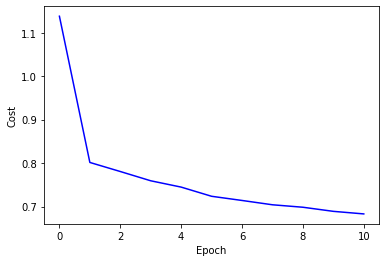

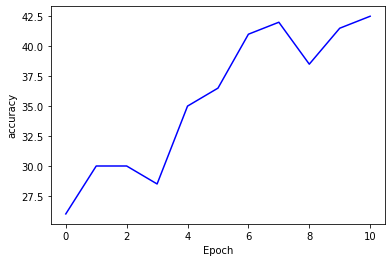

Accuracy of NN after training: 42.5%
Training Time: 99.79740595817566s


In [96]:
class NeuralNetwork:
  '''This is a base class for nerual network.'''
  
  def __init__(self, hidden_layers_sizes: list, input_data, labels, batch_size = 16, alpha = 0.3, epochs=10):
    self.input_data = np.copy(input_data)
    self.labels = np.copy(labels)
    self.num_of_data = input_data.shape[0]
    self.batch_size = batch_size
    self.alpha = alpha
    self.epochs = epochs
    self.hidden_layers_sizes = hidden_layers_sizes

  def sigmoid(self, z):
    return 1 /(1 + np.exp(-z))

  def calc_accuracy(self):
    correct = 0
    for i in range(self.num_of_data):
      self.forward_prop(i)
      index = np.argmax(self.a[-1])
      if self.labels[i][index] == 1:
        correct += 1
    return correct / self.num_of_data * 100
  
  def cost(self):
    s = 0
    for i in range(self.num_of_data):
      self.forward_prop(i)
      diff = self.a[-1] - self.labels[i].reshape(self.a[-1].shape[0], 1)
      s += np.matmul(diff.T, diff)
    return s[0,0] / self.num_of_data
  
  def create_weight_vectors(self):
    weights = []
    #adding first hidden layer weights
    weights.append(np.random.normal(0, 1, size = (self.hidden_layers_sizes[0], self.input_data.shape[1])))
    # adding other hidden layer weights
    for i in range(len(self.hidden_layers_sizes) - 1):
      weights_i = np.random.normal(0, 1, size=(self.hidden_layers_sizes[i + 1], self.hidden_layers_sizes[i]))
      weights.append(weights_i)
    # adding output layer weights
    weights.append(np.random.normal(0, 1, size = (self.labels.shape[1], self.hidden_layers_sizes[-1])))
    return weights

  def create_weight_gradient_vectors(self):
    weights_gradient = []
    #adding first hidden layer weights gradient
    weights_gradient.append(np.zeros((self.hidden_layers_sizes[0], self.input_data.shape[1]), dtype=np.float64))
    # adding other hidden layer weights gradient
    for i in range(len(self.hidden_layers_sizes) - 1):
      weights_i = np.zeros((self.hidden_layers_sizes[i + 1], self.hidden_layers_sizes[i]), dtype=np.float64)
      weights_gradient.append(weights_i)
    # adding output layer weights gradient
    weights_gradient.append(np.zeros((self.labels.shape[1], self.hidden_layers_sizes[-1]), dtype=np.float64))
    return weights_gradient

class NonVectorizedNeuralNetwork(NeuralNetwork):

  def __init__(self, hidden_layers_sizes: list, input_data, labels, batch_size = 16, alpha = 0.3, epochs=10):
    super().__init__(hidden_layers_sizes, input_data, labels, batch_size = batch_size, alpha = alpha, epochs=epochs)
    
    self.weights = self.create_weight_vectors()
    self.weights_gradient = self.create_weight_gradient_vectors()
    self.biases = self.__create_zero_vectors();
    self.biases_gradient = self.__create_zero_vectors();
    self.a = self.__create_zero_vectors();
    self.a_gradient = self.__create_zero_vectors();
    self.nets = self.__create_zero_vectors();
  
  def __create_zero_vectors(self):
    vectors = []
    #adding first hidden layer
    vectors.append(np.zeros((self.input_data.shape[1], 1), dtype=np.float64))
    # adding other hidden layer
    for i in range(len(self.hidden_layers_sizes)):
      bias_i = np.zeros((self.hidden_layers_sizes[i], 1), dtype=np.float64)
      vectors.append(bias_i)
    # adding output layer
    vectors.append(np.zeros((self.labels.shape[1], 1), dtype=np.float64))
    return vectors

  def forward_prop(self, i: int):
    self.a[0] = self.input_data[i].reshape(self.input_data.shape[1], 1)
    for i in range(len(self.a) - 1):
      self.nets[i + 1] = np.matmul(self.weights[i], self.a[i]) + self.biases[i + 1]
      self.a[i + 1] = self.sigmoid(self.nets[i + 1])
      

  def back_prop(self):
    costs = [self.cost()]
    accuracies = [self.calc_accuracy()]
    epochs = [0]
    # iterating each epoch
    for i in range(self.epochs):
      # shuffle the data
      self.input_data, self.labels = shuffle_together(self.input_data, self.labels)
      for j in range(self.num_of_data // self.batch_size + 1):
        # creating weights and bias gradient matrices
        weights_gradient = self.create_weight_gradient_vectors()
        biases_gradient = self.__create_zero_vectors()

        # determine range of the batch
        start_data = j * self.batch_size
        end_data = (j + 1) * self.batch_size
        end_data = min(self.num_of_data, end_data)
          
        for k in range(start_data, end_data):
          # forward prop for each data in batch
          self.forward_prop(k)

          # backprop for each data in batch
          self.__calc_back_prop_gradient(k)

          # sum gradients for eacg data in batch
          for p in range(len(weights_gradient)):
            weights_gradient[p] += self.weights_gradient[p]
            biases_gradient[p] += self.biases_gradient[p]
          biases_gradient[-1] += self.biases_gradient[-1]
        
        # update weights and biases
        for k in range(len(weights_gradient)):
          self.weights[k] -= self.alpha * (weights_gradient[k] / self.batch_size)
          self.biases[k] -= self.alpha * (biases_gradient[k] / self.batch_size)
        self.biases[-1] -= self.alpha * (biases_gradient[-1] / self.batch_size)

      costs.append(self.cost())
      accuracies.append(self.calc_accuracy())
      epochs.append(i + 1)
    return epochs, costs, accuracies
  


  def __calc_back_prop_gradient(self, j):
    # calculate gradient of the last layer with respect to a
    for i in range(self.a_gradient[-1].shape[0]):
      self.a_gradient[-1][i, 0] = 2 * (self.a[-1][i, 0] - self.labels[j][i])
    
    for i in range(len(self.a) - 1, 0, -1):
      # update bias gradient of layer i
      for k in range(self.biases_gradient[i].shape[0]):
        self.biases_gradient[i][k, 0] = self.a_gradient[i][k, 0] * self.sigmoid(self.nets[i][k, 0]) * (1 - self.sigmoid(self.nets[i][k, 0]))
      
      # update weights gradient of layer i - 1
      for k in range(self.weights_gradient[i - 1].shape[0]):
        for p in range(self.weights_gradient[i - 1].shape[1]):
          self.weights_gradient[i - 1][k, p] = self.biases_gradient[i][k, 0] * self.a[i -1][p, 0]

      # update A gradient of layer i - 1
      for k in range(self.a_gradient[i - 1].shape[0]):
        s = 0
        for p in range(self.biases_gradient[i].shape[0]):
          s += self.biases_gradient[i][p, 0] * self.weights[i - 1][p, k]
        self.a_gradient[i - 1][k, 0] = s
    
  def print_weights(self):
    for i in range(len(self.a) - 1, 0, -1):
      print(f"a {i}:\n {self.a[i]}")
      print(f"b {i}:\n {self.biases[i]}")
      print(f"w {i}:\n {self.weights[i - 1]}")

      print(f"a gradient {i}:\n {self.a_gradient[i]}")
      print(f"b gradient {i}:\n {self.biases_gradient[i]}")
      print(f"w gradient {i}:\n {self.weights_gradient[i - 1]}")


def plot_diagram(x, y, xlabel='Epoch', ylabel='Cost'):
  plt.figure()
  plt.plot(x, y, 'b')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()
    

nn = NonVectorizedNeuralNetwork([16,16], train_images[:200], train_labels[:200])
print(f"Accuracy of NN without training: {nn.calc_accuracy()}%")
start_time = time.time()
epochs, costs, acc = nn.back_prop()
end_time = time.time()
plot_diagram(epochs, costs)
plot_diagram(epochs, acc, ylabel='accuracy')
print(f"Accuracy of NN after training: {nn.calc_accuracy()}%")
print(f"Training Time: {end_time - start_time}s")

# Implementing The Vectorized Neural Network

In the previous section I used vectorized form of calculation in forward propagation but not for back propagation. In this section I convert the previous back propagation code to the vectorized form.

Accuracy of NN without training: 20.0%


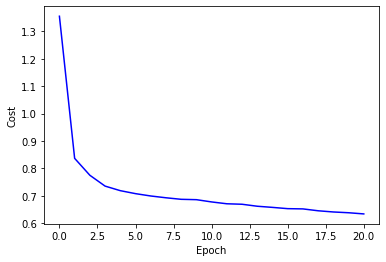

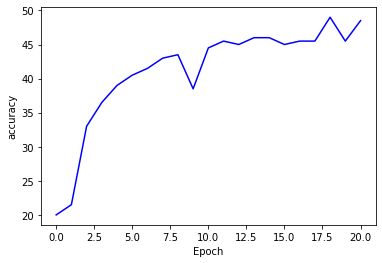

Accuracy of NN after training: 48.5%
Training Time: 0.3777618408203125s


In [108]:
class VectorizedNeuralNetwork(NeuralNetwork):
  def __init__(self, hidden_layers_sizes, input_data, labels, batch_size = 16, alpha = 0.3, epochs=10):
    super().__init__(hidden_layers_sizes, input_data, labels, batch_size = batch_size, alpha = alpha, epochs=epochs)

    self.weights = self.create_weight_vectors()
    self.weights_gradient = self.create_weight_gradient_vectors()
    self.biases = None
    self.biases_gradient = None
    self.a = None
    self.a_gradient = None
    self.nets = None

  def set_new_data(self, input_data, labels):
    self.input_data = np.copy(input_data)
    self.labels = np.copy(labels)
    self.num_of_data = input_data.shape[0]

  def __create_zero_vectors(self, sample_size):
    vectors = []
    #adding first hidden layer
    vectors.append(np.zeros((self.input_data.shape[1], sample_size), dtype=np.float64))
    # adding other hidden layer
    for i in range(len(self.hidden_layers_sizes)):
      bias_i = np.zeros((self.hidden_layers_sizes[i], sample_size), dtype=np.float64)
      vectors.append(bias_i)
    # adding output layer
    vectors.append(np.zeros((self.labels.shape[1], sample_size), dtype=np.float64))
    return vectors

  def calc_accuracy(self):
    self.forward_prop(self.input_data.T)
    diff = np.argmax(self.a[-1], axis = 0) - np.argmax(self.labels.T, axis = 0)
    return np.count_nonzero(diff==0) / self.num_of_data * 100

  def forward_prop(self, X):
    self.a = self.__create_zero_vectors(X.shape[1])
    self.a_gradient = self.__create_zero_vectors(X.shape[1])
    self.biases = self.__create_zero_vectors(X.shape[1])
    self.biases_gradient = self.__create_zero_vectors(X.shape[1])
    self.nets = self.__create_zero_vectors(X.shape[1])

    self.a[0] = X
    for i in range(len(self.a) - 1):
      self.nets[i + 1] = np.matmul(self.weights[i], self.a[i]) + self.biases[i + 1]
      self.a[i + 1] = self.sigmoid(self.nets[i + 1])
  
  def cost(self):
    self.forward_prop(self.input_data.T)
    diff = self.a[-1] - self.labels.T
    s = np.sum(diff * diff)
    return s / self.num_of_data

  def back_prop(self):
    costs = [self.cost()]
    accuracies = [self.calc_accuracy()]
    epochs = [0]
    # iterating each epoch
    for i in range(self.epochs):
      #shuffle the data
      self.input_data, self.labels = shuffle_together(self.input_data, self.labels)
      for j in range(self.num_of_data // self.batch_size + 1):
        # determine range of the batch
        start_data = j * self.batch_size
        end_data = (j + 1) * self.batch_size
        end_data = min(self.num_of_data, end_data)    

        # creating weight and bias gradient matrices
        weights_gradient = self.create_weight_gradient_vectors()
        biases_gradient = self.__create_zero_vectors(end_data - start_data)
        
        # forward prop
        batch_data = self.input_data[start_data:end_data]
        self.forward_prop(batch_data.T)

        # calculate backprop gradients
        self.__calc_back_prop_gradient(start_data, end_data)

        # sum gradients
        for p in range(len(weights_gradient)):
            weights_gradient[p] += self.weights_gradient[p]
            biases_gradient[p] += self.biases_gradient[p]
        biases_gradient[-1] += self.biases_gradient[-1]
        
        # update weights and biases
        for k in range(len(weights_gradient)):
          self.weights[k] -= self.alpha * (weights_gradient[k] / self.batch_size)
          self.biases[k] -= self.alpha * (biases_gradient[k] / self.batch_size)
        self.biases[-1] -= self.alpha * (biases_gradient[-1] / self.batch_size)
      
      costs.append(self.cost())
      accuracies.append(self.calc_accuracy())
      epochs.append(i + 1)
    return epochs, costs, accuracies

  def __calc_back_prop_gradient(self, i, j):
    # calculate gradient of the last layer with respect to a
    self.a_gradient[-1] = 2 * (self.a[-1] - self.labels[i:j].T)
    
    for i in range(len(self.a) - 1, 0, -1):
      # update bias gradient of layer i
      self.biases_gradient[i] = self.a_gradient[i] * self.sigmoid(self.nets[i]) * (1 - self.sigmoid(self.nets[i]))
      
      # update weights gradient of layer i - 1
      self.weights_gradient[i - 1] = np.matmul(self.biases_gradient[i], self.a[i - 1].T)

      # update A gradient of layer i - 1
      self.a_gradient[i - 1] = np.matmul(self.weights[i - 1].T, self.biases_gradient[i])

nn = VectorizedNeuralNetwork([16,16], train_images[:200], train_labels[:200], epochs=20)
print(f"Accuracy of NN without training: {nn.calc_accuracy()}%")
start_time = time.time()
epochs, costs, acc = nn.back_prop()
end_time = time.time()
plot_diagram(epochs, costs)
plot_diagram(epochs, acc, ylabel='accuracy')
print(f"Accuracy of NN after training: {nn.calc_accuracy()}%")
print(f"Training Time: {end_time - start_time}s")


Now I run the code above 10 times to get the average of results.

In [99]:
sum_time = 0
sum_acc = 0
for i in range(10):
  nn = VectorizedNeuralNetwork([16,16], train_images[:200], train_labels[:200], epochs=20)
  start_time = time.time()
  epochs, costs, acc = nn.back_prop()
  end_time = time.time()
  sum_time += end_time - start_time
  sum_acc += acc[-1]

print(f"Average time: {sum_time / 10}s")
print(f"Average accuracy: {sum_acc / 10}%")

Average time: 0.40035827159881593s
Average accuracy: 44.7%


# Testing The Network

Now we can test the network with more data. I'll use 8000 data from our 4 classes.

Accuracy of NN without training (Training set): 24.775%


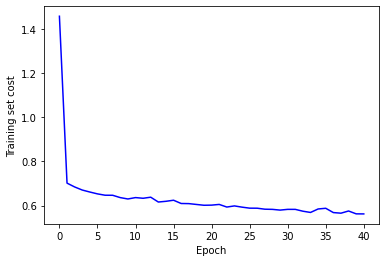

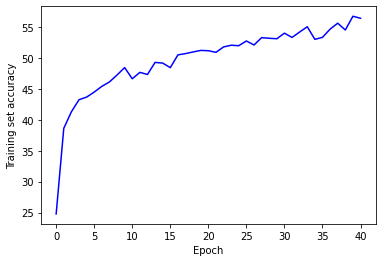

Accuracy of NN after training (Training set): 56.4125%
Training Time: 22.359435558319092s

Accuracy of NN after training (Test set): 53.37499999999999%


In [111]:
train_images, train_labels = shuffle_together(train_images, train_labels)

# Train the network
nn = VectorizedNeuralNetwork([16,16], train_images[:8000], train_labels[:8000], epochs=40)
print(f"Accuracy of NN without training (Training set): {nn.calc_accuracy()}%")
start_time = time.time()
epochs, costs, acc = nn.back_prop()
end_time = time.time()
plot_diagram(epochs, costs, ylabel='Training set cost')
plot_diagram(epochs, acc, ylabel='Training set accuracy')
print(f"Accuracy of NN after training (Training set): {nn.calc_accuracy()}%")
print(f"Training Time: {end_time - start_time}s\n")

# Calculate accuracy of test set
test_images, test_labels = shuffle_together(test_images, test_labels)
nn.set_new_data(test_images, test_labels)
print(f"Accuracy of NN after training (Test set): {nn.calc_accuracy()}%")

Now we can repeat this process to get the average accuracy of network.

In [112]:
sum_time = 0
sum_train_acc = 0
sum_test_acc = 0
for i in range(10):
  # Train the network
  train_images, train_labels = shuffle_together(train_images, train_labels)
  nn = VectorizedNeuralNetwork([16,16], train_images[:8000], train_labels[:8000], epochs=40)

  # Calculate time and accuracy of training
  start_time = time.time()
  epochs, costs, acc = nn.back_prop()
  end_time = time.time()
  sum_time += end_time - start_time
  sum_train_acc += nn.calc_accuracy()

  # Calculate accuracy of test set
  test_images, test_labels = shuffle_together(test_images, test_labels)
  nn.set_new_data(test_images, test_labels)
  sum_test_acc += nn.calc_accuracy()

print(f"Average accuracy of NN after training (Training set): {sum_train_acc / 10}%")
print(f"Average accuracy of NN after training (Test set): {sum_test_acc / 10}%")
print(f"Average training time: {sum_time / 10}s\n")

Average accuracy of NN after training (Training set): 55.49125%
Average accuracy of NN after training (Test set): 52.456500000000005%
Average training time: 21.98535327911377s

